Processing image: /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_what/ind15_0.png from folder: /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_png_0
288 240


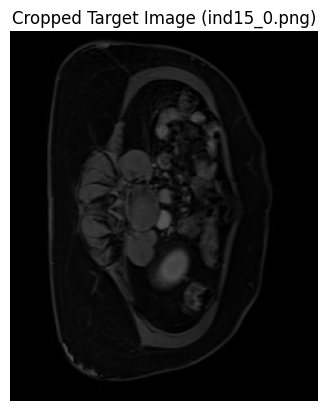

Top Matches:
1: 401402553_MR_2.nii_0.png - Matches: 204
2: 401396535_MR_2.nii_0.png - Matches: 143
3: 401397963_MR_2.nii_0.png - Matches: 138
The most similar image for ind0 is: 401402553_MR_2.nii_0.png with 204 matches
Processing image: /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_what/ind15_80.png from folder: /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_png_80
288 240


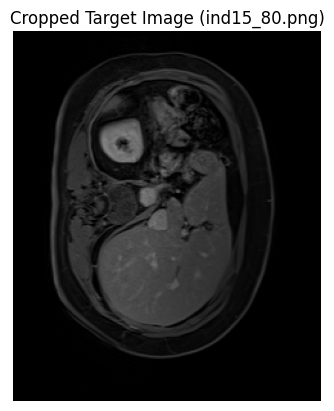

Top Matches:
1: 401402553_MR_2.nii_80.png - Matches: 237
2: 401400274_MR_3.nii_80.png - Matches: 171
3: 401425924_MR_3.nii_80.png - Matches: 164
The most similar image for ind80 is: 401402553_MR_2.nii_80.png with 237 matches
Processing image: /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_what/ind15_160.png from folder: /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_png_160
288 240


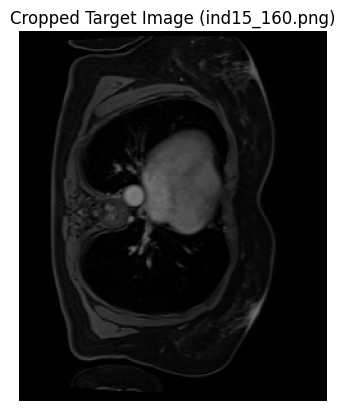

Top Matches:
1: 401402553_MR_2.nii_160.png - Matches: 206
2: 401741594_MR_3.nii_160.png - Matches: 125
3: 401393171_MR_1.nii_160.png - Matches: 125
The most similar image for ind160 is: 401402553_MR_2.nii_160.png with 206 matches


In [44]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append((filename, img))
    return images

def crop_image(image):
    height, width = image.shape[:2]
    start_x = int(width * 2 / 3)
    cropped_image = image[:, start_x:width]
    height, width = cropped_image.shape[:2]
    print(height, width)  # Print dimensions
    return cropped_image

def compute_keypoints_and_descriptors(image):
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

def match_descriptors(desc1, desc2):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desc1, desc2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

def find_most_similar_image(target_image_path, folder_path):
    target_image = cv2.imread(target_image_path)
    if target_image is None:
        print(f"Error: Could not load target image at {target_image_path}.")
        return None, 0

    target_image_cropped = crop_image(target_image)

    # Plot and show the cropped target image
    plt.imshow(cv2.cvtColor(target_image_cropped, cv2.COLOR_BGR2RGB))
    plt.title(f'Cropped Target Image ({os.path.basename(target_image_path)})')
    plt.axis('off')
    plt.show()

    images = load_images_from_folder(folder_path)
    results = []

    _, target_descriptors = compute_keypoints_and_descriptors(target_image_cropped)

    for filename, img in images:
        _, img_descriptors = compute_keypoints_and_descriptors(img)
        matches = match_descriptors(target_descriptors, img_descriptors)
        results.append((filename, len(matches)))

    results.sort(key=lambda x: x[1], reverse=True)

    if results:
        best_match_name = results[0][0]
        best_match_count = results[0][1]
        print("Top Matches:")
        for i in range(min(3, len(results))):
            print(f"{i + 1}: {results[i][0]} - Matches: {results[i][1]}")
    else:
        best_match_name = None
        best_match_count = 0

    return best_match_name, best_match_count

# Example usage:
base_folder_path = '/home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/'

# List of indexes to check
indexes = ['0', '80', '160']

for idx in indexes:
    target_image_path = f'/home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_what/ind15_{idx}.png'
    folder_path = os.path.join(base_folder_path, f'MR_png_{idx}')  # Dynamic folder path
    print(f"Processing image: {target_image_path} from folder: {folder_path}")
    most_similar_image, best_match_count = find_most_similar_image(target_image_path, folder_path)
    
    if most_similar_image:
        print(f'The most similar image for ind{idx} is: {most_similar_image} with {best_match_count} matches')
    else:
        print(f'No similar image found for ind{idx} or the target image does not exist.')


In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

def extract_and_save_slices_from_folder(folder_path, output_folder):
    # Ensure the output directory exists
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(folder_path):
        if filename.endswith('.nii.gz'):
            nifti_file_path = os.path.join(folder_path, filename)
            print(f'Processing {nifti_file_path}...')

            # Load the NIfTI file
            nifti_image = nib.load(nifti_file_path)
            image_data = nifti_image.get_fdata()

            # Get the original filename without the extension
            original_filename = os.path.splitext(os.path.basename(nifti_file_path))[0]

            # Define the slice indices to extract
            slice_indices = [0, 80, 160]

            for idx in slice_indices:
                if idx < image_data.shape[2]:  # Check if the index is within the range of the image data
                    slice_data = image_data[:, :, idx]  # Extract the specified slice

                    # Save the slice as a .png file
                    plt.imshow(slice_data, cmap='gray')  # Display the slice in grayscale
                    plt.axis('off')  # Hide axes
                    output_file_path = os.path.join(output_folder, f'{original_filename}_{idx}.png')
                    plt.savefig(output_file_path, bbox_inches='tight', pad_inches=0)  # Save the figure
                    plt.close()  # Close the figure to avoid memory issues
                    print(f'Saved slice {idx} as {output_file_path}')
                else:
                    print(f'Slice index {idx} does not exist in the image.')

# Example usage:
folder_path = '/home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR'
output_folder = '/home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_png'

extract_and_save_slices_from_folder(folder_path, output_folder)


Processing /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR/401383507_MR_4.nii.gz...
Saved slice 0 as /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_png/401383507_MR_4.nii_0.png
Saved slice 80 as /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_png/401383507_MR_4.nii_80.png
Saved slice 160 as /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_png/401383507_MR_4.nii_160.png
Processing /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR/400182218_MR_1.nii.gz...
Saved slice 0 as /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_png/400182218_MR_1.nii_0.png
Saved slice 80 as /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_png/400182218_MR_1.nii_80.png
Saved slice 160 as /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_png/400182218_MR_1.nii_160.png
Processing /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR/400831063_MR_4.nii.gz...
Saved slice 0 as /home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_png/400831063_MR_4.nii_0.png
Saved sl

In [20]:
import os
import shutil

def transfer_files_with_suffix(source_folder, target_folder, suffix='_80.png'):
    # Ensure the target folder exists
    os.makedirs(target_folder, exist_ok=True)

    # List all files in the source folder
    for filename in os.listdir(source_folder):
        # Check if the file ends with the specified suffix
        if filename.endswith(suffix):
            # Construct full file path
            src_file_path = os.path.join(source_folder, filename)
            dst_file_path = os.path.join(target_folder, filename)

            # Transfer the file
            shutil.move(src_file_path, dst_file_path)
            print(f'Transferred: {filename}')

# Example usage
source_folder = '/home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_png'  # Replace with your source folder path
target_folder = '/home/radiology/Clara_intern/DataBaseWB_NII_Pix2Pix/MR_png_80'  # Replace with your target folder path

transfer_files_with_suffix(source_folder, target_folder)


Transferred: 401422594_MR_1.nii_80.png
Transferred: 401396238_MR_4.nii_80.png
Transferred: 401422594_MR_4.nii_80.png
Transferred: 400182218_MR_3.nii_80.png
Transferred: 401391227_MR_3.nii_80.png
Transferred: 401422355_MR_1.nii_80.png
Transferred: 400759374_MR_2.nii_80.png
Transferred: 401397918_MR_1.nii_80.png
Transferred: 401380920_MR_4.nii_80.png
Transferred: 401398248_MR_3.nii_80.png
Transferred: 401380920_MR_1.nii_80.png
Transferred: 401314984_2_MR_1.nii_80.png
Transferred: 401397918_MR_2.nii_80.png
Transferred: 401400274_MR_2.nii_80.png
Transferred: 401416116_MR_1.nii_80.png
Transferred: 401396238_MR_1.nii_80.png
Transferred: 401425924_MR_1.nii_80.png
Transferred: 401378138_MR_1.nii_80.png
Transferred: 401398248_MR_2.nii_80.png
Transferred: 400182218_MR_2.nii_80.png
Transferred: 400140458_MR_4.nii_80.png
Transferred: 401398314_MR_2.nii_80.png
Transferred: 401731384_MR_4.nii_80.png
Transferred: 401383507_MR_1.nii_80.png
Transferred: 400140458_MR_2.nii_80.png
Transferred: 401416116_